In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Preparacion de Datos

In [2]:
#VIEJO
# Update the paths to point to your image directories with forward slashes
base_dir = r'C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/image_set'  # Base directory
train_dir = base_dir + r'/train'
val_dir = base_dir + r'/val'
test_dir = base_dir + r'/test'

# Image data generators with data augmentation for the training set
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

# Validation and test data generators without augmentation
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the training data with target size set to 256x256 (since your images are already that size)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(256, 256), 
                                                    batch_size=32, class_mode='categorical')

# Load the validation data with target size 256x256
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(256, 256), 
                                                batch_size=32, class_mode='categorical')

# Load test data with target size 256x256
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(256, 256), 
                                                  batch_size=32, class_mode='categorical')

Found 1957 images belonging to 21 classes.
Found 456 images belonging to 21 classes.
Found 433 images belonging to 21 classes.


## Entrenamiento del Modelo

In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the Xception model as a base (pretrained on ImageNet)
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

base_model = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Freeze the pretrained model layers

# Build the full model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Set a lower initial learning rate
low_lr = 0.0005
# Compile the model with the adjusted learning rate
model.compile(optimizer=Adam(learning_rate=low_lr), loss='categorical_crossentropy', metrics=['accuracy'])
# Reduce learning rate if the validation loss doesn't improve for 2 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)



# Define class weights
class_weights = {
    0: 1.0,   # Airplane
    1: 1.0,   # Ambulance
    2: 1.0,   # Bicycle
    3: 1.0,   # Boat
    4: 1.0,   # Bus
    5: 1.0,   # Car
    6: 1.0,   # Fire Truck
    7: 1.0,   # Helicopter
    8: 1.0,   # Hovercraft
    9: 1.0,   # Jet Ski
    10: 1.0,  # Kayak
    11: 1.0,  # Motorcycle
    12: 1.0,  # Rickshaw
    13: 1.0,  # Scooter
    14: 1.0,  # Segway
    15: 1.0,  # Skateboard
    16: 1.0,  # Tractor
    17: 1.0,  # Train
    18: 1.0,  # Truck
    19: 1.0,  # Unicycle
    20: 1.0   # Van
}

# Early stopping to stop training when validation loss is not improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 8, 8, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 21)             │        21,525 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,981,181 (87.67 MB)

 Trainable params: 2,119,701 (8.09 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [4]:
# Train the model

history = model.fit(train_generator, 
                    epochs=20, 
                    validation_data=val_generator, 
                    class_weight=class_weights,
                    callbacks=[early_stopping, reduce_lr])

test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

Epoch 1/20


c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/62 ━━━━━━━━━━━━━━━━━━━━ 2:16 3s/step - accuracy: 0.2442 - loss: 2.7431

c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


62/62 ━━━━━━━━━━━━━━━━━━━━ 241s 4s/step - accuracy: 0.4861 - loss: 1.8954 - val_accuracy: 0.8947 - val_loss: 0.3672 - learning_rate: 5.0000e-04
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 234s 4s/step - accuracy: 0.8332 - loss: 0.5527 - val_accuracy: 0.8947 - val_loss: 0.3135 - learning_rate: 5.0000e-04
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 233s 4s/step - accuracy: 0.8609 - loss: 0.4717 - val_accuracy: 0.9232 - val_loss: 0.2554 - learning_rate: 5.0000e-04
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 227s 4s/step - accuracy: 0.8770 - loss: 0.3890 - val_accuracy: 0.9013 - val_loss: 0.2987 - learning_rate: 5.0000e-04
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8686 - loss: 0.4206
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
62/62 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step - accuracy: 0.8687 - loss: 0.4201 - val_accuracy: 0.9013 - val_loss: 0.3024 - learning_rate: 5.0000e-04
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 228s 4s/step - accuracy: 0.8812 - loss: 0.3640 - v

Guardar el modelo

In [5]:
model.save('C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/Modelos/vehiculos_11.keras')

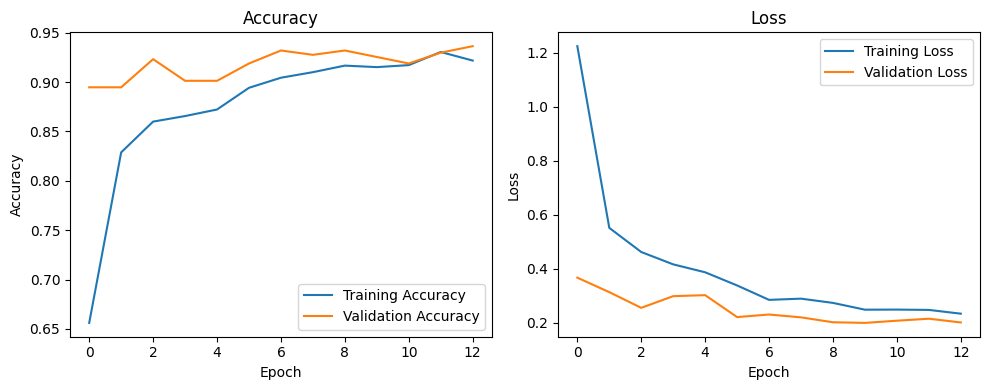

In [6]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Display the plots
plt.tight_layout()
plt.show()


In [9]:
from docx import Document
from docx.shared import Pt, Inches
from docx.oxml.ns import nsdecls
from docx.oxml import parse_xml
from docx.enum.section import WD_ORIENT, WD_SECTION

# Load the existing document
doc_path = 'C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/Modelos/entrenamiento_modelos.docx'
doc = Document(doc_path)

# Add a new section to start on a new page at the end of the document
new_section = doc.add_section(WD_SECTION.NEW_PAGE)

# Explicitly set the orientation of the new section to landscape
new_section.orientation = WD_ORIENT.LANDSCAPE
new_section.page_width = Inches(11)  # Width for landscape orientation
new_section.page_height = Inches(8.5)  # Height for landscape orientation

# Set the top and bottom margins to 0 for the new section
new_section.top_margin = Inches(0)
new_section.bottom_margin = Inches(0)

########################
# Data Writing Section Starts Here

# Add a heading with the model and accuracy information 
mod_accuracy = 0.9594
mod_loss = 0.1621

doc.add_heading(f'Modelo: vehiculos_11 / model11 | Accuracy: {mod_accuracy} | Loss: {mod_loss}', level=1)

# Add a subheading for the table
doc.add_heading('Tabla de Accuracy y Loss por Epoca', level=2)

# Prepare data for table insertion using history from model training
metrics = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
table_data = [['Epoch'] + metrics]  # Header row
num_epochs = len(history.history['accuracy'])

# Populate rows with metric values for each epoch
for epoch in range(num_epochs):
    row = [epoch + 1]  # Start epoch numbering from 1
    for metric in metrics:
        row.append(round(history.history[metric][epoch], 4))
    table_data.append(row)

# Add the table to the document
table = doc.add_table(rows=1, cols=len(table_data[0]))

# Add header row
hdr_cells = table.rows[0].cells
for i, col_name in enumerate(table_data[0]):
    hdr_cells[i].text = str(col_name)

# Add the rest of the data rows
for row_data in table_data[1:]:
    row_cells = table.add_row().cells
    for i, cell_data in enumerate(row_data):
        row_cells[i].text = str(cell_data)

# Add borders to all table cells and adjust spacing
for row in table.rows:
    for cell in row.cells:
        # Add border to each cell
        tc = cell._element.get_or_add_tcPr()
        tc.append(parse_xml(r'<w:tcBorders %s><w:top w:val="single"/><w:left w:val="single"/><w:bottom w:val="single"/><w:right w:val="single"/></w:tcBorders>' % nsdecls('w')))
        
        # Reduce cell padding/margins
        cell.margin_top = Pt(0)
        cell.margin_bottom = Pt(0)
        cell.margin_left = Pt(0)
        cell.margin_right = Pt(0)

# Add another heading for the graph
doc.add_heading('Grafico  de Accuracy y Loss', level=2)

# Add the image of the plot
graph_path = 'C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/Modelos/graficos/training_metrics_graph.png'
doc.add_picture(graph_path, width=Inches(5))

# Data Writing Section Ends Here
########################

# Save the modified document
doc.save(doc_path)

print(f"Document saved to {doc_path}")


Document saved to C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/Modelos/entrenamiento_modelos.docx


In [8]:
# cargar modelos
from tensorflow.keras.models import load_model
#model1 = load_model('C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/Modelos/vehiculos.keras')
#model2 = load_model('C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/Modelos/vehiculos_con_weights.keras')
model3 = load_model('C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/Modelos/vehiculos_con_weights_learning_rate0005.keras')
#model4 = load_model('C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/Modelos/vehiculos_con_weights_learning_rate0005_final(no_final).keras')
model5 = load_model('C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/Modelos/vehiculos_opening_latino(HD).keras')
#model6 = load_model('C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/Modelos/vehiculos_vehiculos.keras')
#model7 = load_model('C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/Modelos/vehiculos_vehiculos_wow.keras')
model8 = load_model('C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/Modelos/vehiculos_shrigma.keras')
model9 = load_model('C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/Modelos/vehiculos_9.keras')
model10 = load_model('C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/Modelos/vehiculos_10.keras')
model11 = load_model('C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/Modelos/vehiculos_11.keras')

## Prediccion con una imagen

In [9]:
# Predict on a single image
from tensorflow.keras.preprocessing import image
import numpy as np


In [19]:
img_path = r'C:/Users/diego/Downloads/download.jpg'  # Update this path
img = image.load_img(img_path, target_size=(256, 256))  # Adjust to 256x256
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)


In [ ]:
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
print(f'Predicted class: {predicted_class}')


In [ ]:
label_list = train_generator.class_indices
# Invertimos el diccionario para que podamos buscar los nombres de las clases por índice
label_list = {v: k for k, v in label_list.items()}
predicted_label = label_list[predicted_class]
print(f'This vehicle is predicted to be a: {predicted_label}')


## Analisis del modelo

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Data loading and preparation
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important: Disable shuffling for evaluation
)
# Get the true class labels from the test generator
true_classes = test_generator.classes

# Get the class labels (class names)
class_labels = list(test_generator.class_indices.keys())



Found 433 images belonging to 21 classes.


In [ ]:
# vehiculos_con_weights_learning_rate0005.kera
# Generate predictions on the test set
predictions3 = model3.predict(test_generator)
# Convert predictions to class indices
predicted_classes3 = np.argmax(predictions3, axis=1)

# GENERAR EL REPORTE DEL MODELO
# Generate the classification report as a dictionary
report_dict3 = classification_report(true_classes, predicted_classes3, target_names=class_labels, output_dict=True)
# converetir el diccionario 'report' a df
report_df3 = pd.DataFrame(report_dict3).transpose()
report_df3.iloc[:, :3] *= 100
report_df3.iloc[:, :] = report_df3.iloc[:, :].round(2)
report_df3['support'] = report_df3['support'].astype(int)
report_df3.index.name = 'class'
report_df3.reset_index(inplace=True)


In [ ]:
# vehiculos_opening_latino(HD).kera
# Generate predictions on the test set
predictions5 = model5.predict(test_generator)
# Convert predictions to class indices
predicted_classes5 = np.argmax(predictions5, axis=1)

# GENERAR EL REPORTE DEL MODELO
# Generate the classification report as a dictionary
report_dict5 = classification_report(true_classes, predicted_classes5, target_names=class_labels, output_dict=True)
# converetir el diccionario 'report' a df
report_df5 = pd.DataFrame(report_dict5).transpose()
report_df5.iloc[:, :3] *= 100
report_df5.iloc[:, :] = report_df5.iloc[:, :].round(2)
report_df5['support'] = report_df5['support'].astype(int)
report_df5.index.name = 'class'
report_df5.reset_index(inplace=True)

In [ ]:
# vehiculos_shrigma.kera
# Generate predictions on the test set
predictions8 = model8.predict(test_generator)
# Convert predictions to class indices
predicted_classes8 = np.argmax(predictions8, axis=1)

# GENERAR EL REPORTE DEL MODELO
# Generate the classification report as a dictionary
report_dict8 = classification_report(true_classes, predicted_classes8, target_names=class_labels, output_dict=True)
# converetir el diccionario 'report' a df
report_df8 = pd.DataFrame(report_dict8).transpose()
report_df8.iloc[:, :3] *= 100
report_df8.iloc[:, :] = report_df8.iloc[:, :].round(2)
report_df8['support'] = report_df8['support'].astype(int)
report_df8.index.name = 'class'
report_df8.reset_index(inplace=True)

In [ ]:
# vehiculos_9.kera
# Generate predictions on the test set
predictions9 = model9.predict(test_generator)
# Convert predictions to class indices
predicted_classes9 = np.argmax(predictions9, axis=1)

# GENERAR EL REPORTE DEL MODELO
# Generate the classification report as a dictionary
report_dict9 = classification_report(true_classes, predicted_classes9, target_names=class_labels, output_dict=True)
# converetir el diccionario 'report' a df
report_df9 = pd.DataFrame(report_dict9).transpose()
report_df9.iloc[:, :3] *= 100
report_df9.iloc[:, :] = report_df9.iloc[:, :].round(2)
report_df9['support'] = report_df9['support'].astype(int)
report_df9.index.name = 'class'
report_df9.reset_index(inplace=True)

In [13]:
# vehiculos_10.kera
# Generate predictions on the test set
predictions10 = model10.predict(test_generator)
# Convert predictions to class indices
predicted_classes10 = np.argmax(predictions10, axis=1)

# GENERAR EL REPORTE DEL MODELO
# Generate the classification report as a dictionary
report_dict10 = classification_report(true_classes, predicted_classes10, target_names=class_labels, output_dict=True)
# converetir el diccionario 'report' a df
report_df10 = pd.DataFrame(report_dict10).transpose()
report_df10.iloc[:, :3] *= 100
report_df10.iloc[:, :] = report_df10.iloc[:, :].round(2)
report_df10['support'] = report_df10['support'].astype(int)
report_df10.index.name = 'class'
report_df10.reset_index(inplace=True)

14/14 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step


In [12]:
# vehiculos_11.kera
# Generate predictions on the test set
predictions11 = model11.predict(test_generator)
# Convert predictions to class indices
predicted_classes11 = np.argmax(predictions11, axis=1)

# GENERAR EL REPORTE DEL MODELO
# Generate the classification report as a dictionary
report_dict11 = classification_report(true_classes, predicted_classes11, target_names=class_labels, output_dict=True)
# converetir el diccionario 'report' a df
report_df11 = pd.DataFrame(report_dict11).transpose()
report_df11.iloc[:, :3] *= 100
report_df11.iloc[:, :] = report_df11.iloc[:, :].round(2)
report_df11['support'] = report_df11['support'].astype(int)
report_df11.index.name = 'class'
report_df11.reset_index(inplace=True)

c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step


In [ ]:
print(report_df11)

In [14]:
# PREPARAR DATOS PARA GRAFICOS
precision_data = {
    #'Model 3': report_df3['precision'],
    #'Model 5': report_df5['precision'],
    #'Model 8': report_df8['precision'],
    #'Model 9': report_df9['precision'],
    'Model 10': report_df10['precision'],
    'Model 11': report_df11['precision']
}

precision_df = pd.DataFrame(precision_data)

recall_data = {
    #'Model 3': report_df3['recall'],
    #'Model 5': report_df5['recall'],
    #'Model 8': report_df8['recall'],
    #'Model 9': report_df9['recall'],
    'Model 10': report_df10['recall'],
    'Model 11': report_df11['recall']
}
recall_df = pd.DataFrame(recall_data)


C:\Users\diego\AppData\Local\Temp\ipykernel_27208\2899762668.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(precision_df.values, labels=precision_df.columns, patch_artist=True)


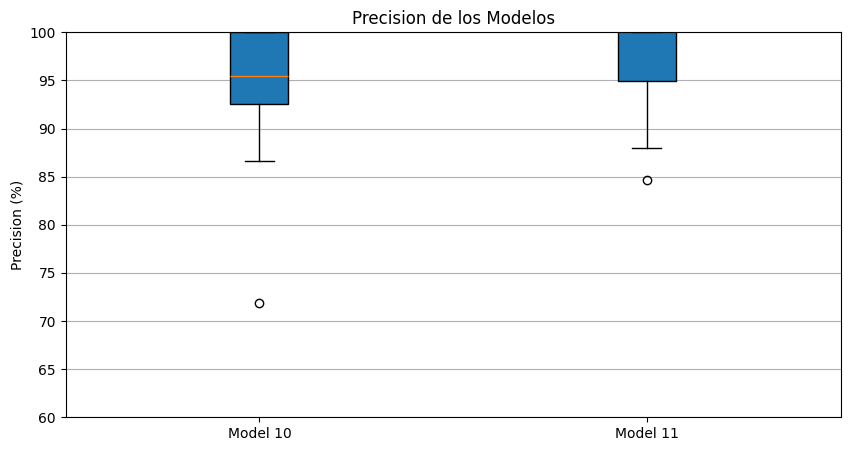

In [15]:
# BOXPLOT
# Create a boxplot
plt.figure(figsize=(10, 5))
plt.boxplot(precision_df.values, labels=precision_df.columns, patch_artist=True)

# Customize the plot
plt.title('Precision de los Modelos')
plt.ylabel('Precision (%)')
plt.grid(axis='y')
plt.ylim(60, 100)

# Show the plot
plt.show()


C:\Users\diego\AppData\Local\Temp\ipykernel_27208\125632067.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(recall_df.values, labels=recall_df.columns, patch_artist=True)


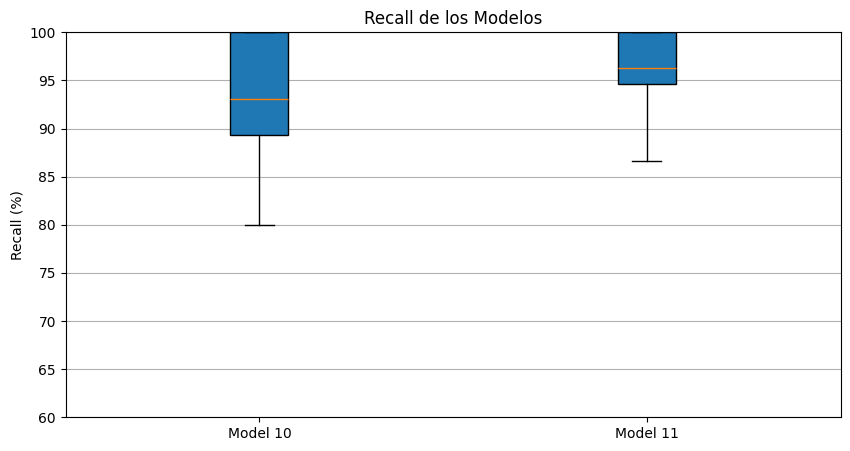

In [16]:
# BOXPLOT
# Create a boxplot
plt.figure(figsize=(10, 5))
plt.boxplot(recall_df.values, labels=recall_df.columns, patch_artist=True)

# Customize the plot
plt.title('Recall de los Modelos')
plt.ylabel('Recall (%)')
plt.grid(axis='y')
plt.ylim(60, 100)

# Show the plot
plt.show()


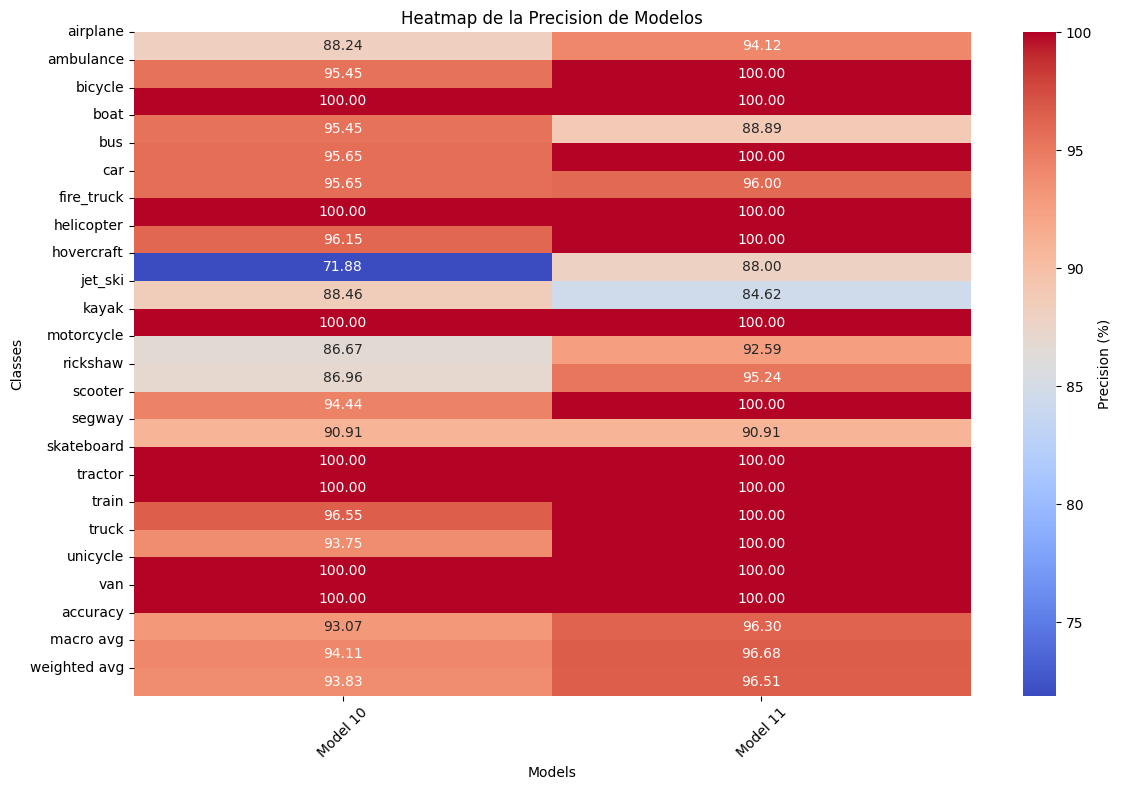

In [17]:
import seaborn as sns

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(precision_df, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Precision (%)'})

# Customize the plot
plt.title('Heatmap de la Precision de Modelos')
plt.xlabel('Models')
plt.ylabel('Classes')
plt.xticks(rotation=45)
plt.yticks(ticks=np.arange(len(report_df10)), labels=report_df10['class'], rotation=0)

# Show the plot
plt.tight_layout()
plt.show()


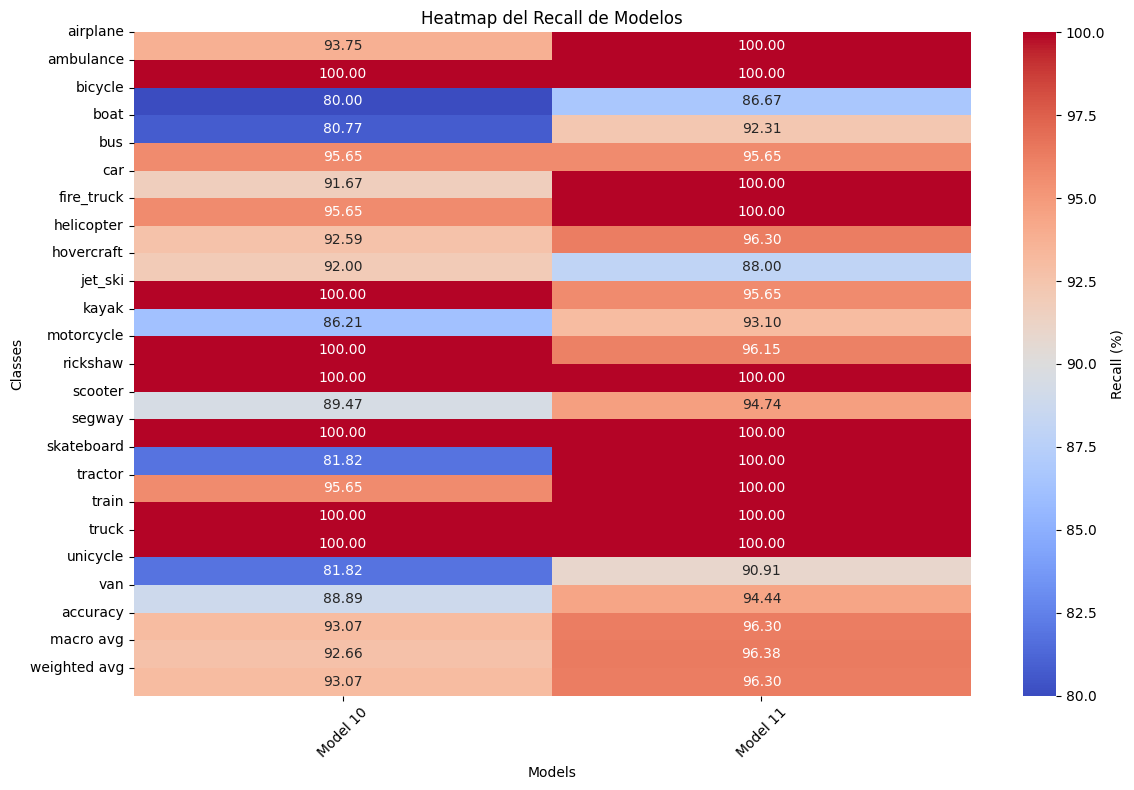

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prepare the DataFrame for plotting recall



# Create a heatmap for recall
plt.figure(figsize=(12, 8))
sns.heatmap(recall_df, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Recall (%)'})

# Customize the plot
plt.title('Heatmap del Recall de Modelos')
plt.xlabel('Models')
plt.ylabel('Classes')
plt.xticks(rotation=45)
plt.yticks(ticks=np.arange(len(report_df10)), labels=report_df10['class'], rotation=0)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# PLOTEAR LA PRECISION

sorted_df = report_df1.sort_values(by='precision')


plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_df['class'], sorted_df['precision'], color=plt.cm.Blues(sorted_df['precision'] / 100))

# agregar los valores al lado de cada barra
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
             f'{int(bar.get_width())}',  
             va='center', ha='left', fontsize=10)

plt.xlabel('Precision (%)')
plt.title('Precision de clasificación de vehículos por clase')
plt.xlim(0, 100) 
plt.grid(axis='x')  
plt.show()

In [ ]:
# PLOTEAR EL RECALL

sorted_df = report_df.sort_values(by='recall')


plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_df['class'], sorted_df['recall'], color=plt.cm.Blues(sorted_df['recall'] / 100))

# agregar los valores al lado de cada barra
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
             f'{int(bar.get_width())}',  
             va='center', ha='left', fontsize=10)

plt.xlabel('Recall (%)')
plt.title('Recall de vehículos por clase')
plt.xlim(0, 100) 
plt.grid(axis='x')  
plt.show()

In [ ]:
# ESCRIBIR A UN .txt DETALLES DE LA PRECISION DE CLASE X

# CLASE A ANALIZAR
target_class = 'airplane' 


# Create a DataFrame for detailed predictions
filenames = test_generator.filenames  # List of filenames corresponding to predictions
probabilities = predictions.tolist()  # List of predicted probabilities for each class

# Create a DataFrame for detailed predictions
detailed_predictions = pd.DataFrame({
    'filename': filenames,
    'predicted_class': [class_labels[i] for i in predicted_classes],
    'probabilities': probabilities
}) 

# filtrar el df para la clase especifica
filtered_predictions = detailed_predictions[detailed_predictions['predicted_class'] == target_class].copy()

# formateo de probabilidades, y escribir solo el top 4 de procentajes
def get_top_predictions(probabilities, class_labels, top_n=4):
    top_indices = np.argsort(probabilities)[-top_n:][::-1] 
    top_probs = {class_labels[i]: f"{probabilities[i] * 100:.3f}%" for i in top_indices}
    return top_probs

filtered_predictions['top_probabilities'] = filtered_predictions['probabilities'].apply(
    lambda x: get_top_predictions(x, class_labels)
)

# guardar las predicciones a un .txt
output_path = r'C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/precision_analisis.txt'
with open(output_path, 'w') as f:
    f.write(f"Detailed Predictions for '{target_class}' Class:\n\n")
    for index, row in filtered_predictions.iterrows():
        f.write(f"Filename: {row['filename']}\n")
        f.write(f"Predicted Class: {row['predicted_class']}\n")
        f.write("Top Probabilities:\n")
        for class_name, probability in row['top_probabilities'].items():
            f.write(f"  {class_name}: {probability}\n")
        f.write("\n")  # Blank line between predictions

print(f'Precision analysis for class "{target_class}" saved to {output_path}')

In [ ]:
# ESCRIBIR A UN .txt DETALLES DEL RECALL DE CLASE X

# CLASE A ANALIZAR
target_class = 'truck'

# Create a DataFrame for detailed predictions
filenames = test_generator.filenames  # List of filenames corresponding to predictions
probabilities = predictions.tolist()  # List of predicted probabilities for each class

# Create a DataFrame for detailed predictions
detailed_predictions = pd.DataFrame({
    'filename': filenames,
    'actual_class': [class_labels[i] for i in true_classes],
    'predicted_class': [class_labels[i] for i in predicted_classes],
    'probabilities': probabilities
})

# Filter the DataFrame for instances of the target class
filtered_recall = detailed_predictions[detailed_predictions['actual_class'] == target_class].copy()

# Function to get the top N predictions
def get_top_predictions(probabilities, class_labels, top_n=4):
    top_indices = np.argsort(probabilities)[-top_n:][::-1]  # Get the indices of the top N probabilities
    top_probs = {class_labels[i]: f"{probabilities[i] * 100:.2f}%" for i in top_indices}
    return top_probs

# Add a column for top predictions
filtered_recall['top_probabilities'] = filtered_recall['probabilities'].apply(
    lambda x: get_top_predictions(x, class_labels)
)

# Save the recall analysis to a .txt file
output_path_recall = r'C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/recall_analysis.txt'
with open(output_path_recall, 'w') as f:
    f.write(f"Recall Analysis for '{target_class}' Class:\n\n")
    for index, row in filtered_recall.iterrows():
        f.write(f"Filename: {row['filename']}\n")
        f.write(f"Predicted Class: {row['predicted_class']}\n")
        f.write("Top Probabilities:\n")
        for class_name, probability in row['top_probabilities'].items():
            f.write(f"  {class_name}: {probability}\n")
        f.write("\n")  # Blank line between predictions

print(f'Recall analysis for class "{target_class}" saved to {output_path_recall}')


In [ ]:
# ver si hay relacion entre el numero de imagenes de muestra y los valores de precision o recall


precision = report_df['precision']
support = report_df['support']
classes = report_df['class']

# Create scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(support, precision, color='blue', s=100, alpha=0.6)

# Label each point with the class name
for i, class_name in enumerate(report_df['class']):
    plt.text(support.iloc[i], precision.iloc[i], class_name, fontsize=9, ha='right')

# Add titles and labels
plt.title('Precision vs Support for Each Class', fontsize=14)
plt.xlabel('Support (Number of Samples)', fontsize=12)
plt.ylabel('Precision (%)', fontsize=12)
plt.grid(True)

# Show plot
plt.show()


In [ ]:
# recall

support = report_df1['support']
recall = report_df1['recall']
classes = report_df1['class']

# Create scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(support, recall, color='blue', s=100, alpha=0.6)

# Label each point with the class name
for i, class_name in enumerate(classes):
    plt.text(support.iloc[i], recall.iloc[i], class_name, fontsize=9, ha='right')

# Add titles and labels
plt.title('Recall vs Support for Each Class', fontsize=14)
plt.xlabel('Support (Number of Samples)', fontsize=12)
plt.ylabel('Recall (%)', fontsize=12)
plt.grid(True)

# Show plot
plt.show()
